# Process data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (50 random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [2]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

sys.path.append("../")
from functions import generate_labeled_data, utils, pipeline

from numpy.random import seed
randomState = 123
seed(randomState)

2020-05-26 11:35:47,176 [27795] WARNING  py.warnings:110: [JupyterRequire] /home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))

Using TensorFlow backend.


In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [4]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']

### Download subset of recount2 to use as a compendium
The compendium will be composed of random experiments + the selected template experiment

In [5]:
%%R
# Select 59
# Run one time
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("recount")

a


Update all/some/none? [a/s/n]: 

In [11]:
%%R
library('recount')

In [7]:
%%R -i project_id -i base_dir -i local_dir

source('../functions/download_recount2_data.R')

get_recount2_compendium(project_id, base_dir, local_dir)

Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  r

### Download expression data for selected project id

In [20]:
%%R -i project_id -i local_dir

source('../functions/download_recount2_data.R')

get_recount2_template_experiment(project_id, local_dir)

Loading objects:
  rse_gene


In [21]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

In [22]:
# This experiment contains both RNA-seq and smRNA-seq samples.
# We will drop smRNA samples so that samples are within the same range
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

In [23]:
# Drop samples
utils.subsample_data(template_data_file,
                    smRNA_samples)

### Normalize compendium 

In [6]:
# Load real gene expression data
original_compendium_file = os.path.join(
    local_dir,
    "recount2_compedium_data.tsv")

In [7]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

print(original_compendium.shape)
original_compendium.head()

(1552, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR1604987,35.467314,0.027332,32.157194,2.358523,2.588223,0.000000,5.738176,43.607106,6.178332,11.840453,...,0.000000,0.164063,0.0,0.0,0.000000,0.104461,0.108411,0.973816,0.001023,0.0
SRR1604988,36.738594,0.014175,31.768894,2.441588,2.879852,0.028577,5.801958,44.476582,5.770250,11.408501,...,0.005034,0.637123,0.0,0.0,0.000000,0.000000,0.126587,0.862680,0.000364,0.0
SRR1604989,23.421167,0.000000,26.339462,2.416182,2.935066,0.000000,4.173785,33.963581,8.310376,11.857877,...,0.000000,0.376129,0.0,0.0,0.000000,0.087597,0.338459,0.633735,0.034451,0.0
SRR1604990,22.413470,0.000000,26.680954,2.747019,3.281573,0.009275,4.233309,33.615684,8.207437,12.296103,...,0.000000,0.112437,0.0,0.0,0.165182,0.000000,0.252239,1.049893,0.004970,0.0
SRR1604991,22.274276,0.000000,28.510716,1.818116,2.095023,0.011248,3.693352,32.073188,4.571614,11.777791,...,0.000000,0.107868,0.0,0.0,0.000000,0.000000,0.179313,0.952988,0.111618,0.0


In [8]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

original_data_scaled_df.head()

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR1604987,0.447304,0.001928,0.148169,0.039812,0.086324,0.000000,0.050946,0.314943,0.108413,0.398045,...,0.0000,0.000636,0.0,0.0,0.000000,0.018424,0.000001,0.051028,0.000175,0.0
SRR1604988,0.463337,0.001000,0.146380,0.041214,0.096051,0.000053,0.051512,0.321223,0.101253,0.383524,...,0.0001,0.002471,0.0,0.0,0.000000,0.000000,0.000002,0.045204,0.000062,0.0
SRR1604989,0.295382,0.000000,0.121363,0.040786,0.097892,0.000000,0.037057,0.245295,0.145825,0.398631,...,0.0000,0.001459,0.0,0.0,0.000000,0.015450,0.000005,0.033208,0.005899,0.0
SRR1604990,0.282673,0.000000,0.122936,0.046370,0.109449,0.000017,0.037585,0.242782,0.144019,0.413363,...,0.0000,0.000436,0.0,0.0,0.010078,0.000000,0.000003,0.055014,0.000851,0.0
SRR1604991,0.280917,0.000000,0.131367,0.030690,0.069874,0.000021,0.032791,0.231642,0.080220,0.395938,...,0.0000,0.000418,0.0,0.0,0.000000,0.000000,0.000002,0.049936,0.019112,0.0


In [9]:
# Save normalized data
normalized_data_file = os.path.join(
    local_dir,
    "normalized_recount2_compendium_data.tsv")

original_data_scaled_df.to_csv(
    normalized_data_file, float_format='%.3f', sep='\t')

# Save scaler transform
scaler_file = os.path.join(
    local_dir,
    "scaler_transform.pickle")

outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 

In [17]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

creating new directory: /home/alexandra/Documents/Repos/simulate-expression-compendia/Rank_pathways/models/NN_2500_30
creating new directory: /home/alexandra/Documents/Repos/simulate-expression-compendia/Rank_pathways/logs/NN_2500_30


input dataset contains 1552 samples and 58037 genes
tracking <tf.Variable 'Variable_1:0' shape=() dtype=float32> beta
Train on 1397 samples, validate on 155 samples
Epoch 1/40
1397/1397 [==============================] - 680s 487ms/step - loss: 8318.1557 - val_loss: 6701.3402
Epoch 2/40
1397/1397 [==============================] - 682s 488ms/step - loss: 6741.8980 - val_loss: 6437.2010
Epoch 3/40
1397/1397 [==============================] - 684s 489ms/step - loss: 6601.7822 - val_loss: 6348.4345
Epoch 4/40
1397/1397 [==============================] - 684s 490ms/step - loss: 6523.0364 - val_loss: 6276.1957
Epoch 5/40
1397/1397 [==============================] - 685s 490ms/step - loss: 6460.0961 - val_loss: 6230.2235
Epoch 6/40
1397/1397 [==============================] - 686s 491ms/step - loss: 6385.1784 - val_loss: 6165.9547
Epoch 7/40
1397/1397 [==============================] - 687s 491ms/step - loss: 6324.9718 - val_loss: 6148.8773
Epoch 8/40
1397/1397 [=============================

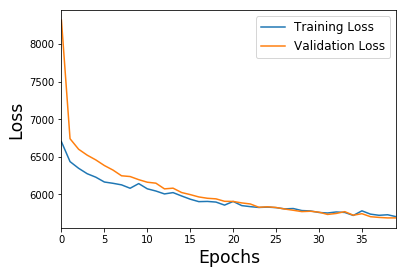

In [14]:
# Train VAE on new compendium data
# Write out model to rank_pathways directory
pipeline.train_vae(config_file,
                   normalized_data_file)